<a href="https://colab.research.google.com/github/peeyushsinghal/AI-Engineering-ERA3/blob/main/Lab_DANN_MNIST_MNIST_M_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Domain Adversarial Neural Network (DANN): MNIST → MNIST-M

This notebook demonstrates how Domain-Adversarial Neural Networks (DANN) help adapt a model trained on MNIST to perform well on MNIST-M without direct supervision. We compare:

- **Baseline Model**: Trained only on source (MNIST) data.
- **DANN Model**: Trained with adversarial domain adaptation between MNIST (source) and MNIST-M (target).

**Key Concepts:**
- Feature Extractor
- Label Classifier
- Domain Classifier
- Gradient Reversal Layer (GRL)
- Domain Adaptation Loss (Domain Confusion)



## 📌 1. Introduction

**Objective**: Train a DANN model using MNIST as the source domain and MNIST-M as the target domain to classify digits. We explore how varying the domain adaptation strength (`alpha`) affects the performance.

**Why MNIST-M?**
MNIST-M blends MNIST digits with real-world image backgrounds, introducing domain shift. It is commonly used for benchmarking domain adaptation algorithms.


## 📦 2. Import Required Libraries


In [ ]:
import torch
import torch.nn as nn # for creating network, modules
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms # for dataloader and dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid # for printing the images
from torch.autograd import Function # for GRL
import matplotlib.pyplot as plt # for plots
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import os
import PIL.Image as Image
import urllib.request
import tarfile
from tqdm import tqdm

In [ ]:
# ⚙️ Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", DEVICE)

Device used: cuda


## 📁 3. Dataset Preparation

- **MNIST**: Grayscale handwritten digits (1 channel).
- **MNIST-M**: Colorized digits using random background patches from BSDS500 images (3 channels).

We normalize both datasets and resize them to 28x28 resolution. MNIST is converted to 3-channel to match MNIST-M.


### 🗃️ Define MNIST-M Dataset Loader


In [ ]:
import os
import tarfile
import urllib.request

def download_and_extract(url, extract_path):
    os.makedirs(extract_path, exist_ok=True)
    filename = url.split('/')[-1]
    download_path = os.path.join(extract_path, filename)

    if not os.path.exists(download_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, download_path)
    else:
        print(f"{filename} already downloaded.")

    print(f"Extracting {filename}...")
    with tarfile.open(download_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print(f"Extraction complete.\n")

# URLs to files
train_url = "https://raw.githubusercontent.com/peeyushsinghal/DA-CV/main/data/train_mnist_m.tar.gz"
test_url = "https://raw.githubusercontent.com/peeyushsinghal/DA-CV/main/data/test_mnist_m.tar.gz"

# Extract to ./data/mnist_m/
download_and_extract(train_url, "./data/mnist_m/")
download_and_extract(test_url, "./data/mnist_m/")


Extracting train_mnist_m.tar.gz...
Extraction complete.

Extracting test_mnist_m.tar.gz...
Extraction complete.



In [ ]:
class MNISTMDataset(Dataset):
    def __init__(self, data_root, data_list, transform=None, num_images = None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        if num_images:
          self.n_data = num_images
        else:
          self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
          if len(self.img_paths) <= self.n_data:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])
          else:
            break

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

### 🔄 Apply Transforms


In [ ]:
image_size = 28
transform_mnist = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert 1-channel to 3-channel
                          transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                          ])
transform_mnistm = transforms.Compose([transforms.Resize(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          ])

### 📤 Load MNIST and MNIST-M


In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]


In [ ]:
data_dir = './data'

mnistm_train = MNISTMDataset(os.path.join(data_dir, 'mnist_m','train_mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'train_mnist_m','mnist_m_train_labels.txt'),
                         transform=transform_mnistm, num_images = 20000)

mnistm_test = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'test_mnist_m','mnist_m_test'),
                          os.path.join(data_dir, 'mnist_m', 'test_mnist_m','mnist_m_test_labels.txt'),
                         transform=transform_mnistm, num_images = 5000)

In [ ]:
# creating dataloaders
batch_size = 128
source_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
source_test_loader = DataLoader(mnist_test,batch_size=batch_size)

target_loader = DataLoader(mnistm_train, batch_size=batch_size, shuffle=True)
target_test_loader = DataLoader(mnistm_test, batch_size=batch_size)

In [ ]:
# size of dataloaders
print(f'size of mnist (source) train:  {len(mnist_train)}')
print(f'size of mnist (source) test:',  len(mnist_test))
print(f'size of mnist-m (target) train',  len(mnistm_train))
print(f'size of mnist-m (target) test',  len(mnistm_test))

size of mnist (source) train:  60000
size of mnist (source) test: 10000
size of mnist-m (target) train 20000
size of mnist-m (target) test 5000


### 🎨 Show samples for both MNIST and MNIST-M
We display random samples from MNIST and MNIST-M datasets to highlight the domain shift.


In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_mnist_and_mnistm_samples(mnist_loader, mnist_m_loader):
    """Display a few sample images from MNIST and MNIST-M datasets"""
    mnist_images, mnist_labels = next(iter(mnist_loader))
    mnist_m_images, mnist_m_labels = next(iter(mnist_m_loader))

    fig, axs = plt.subplots(2, 6, figsize=(12, 4))
    fig.suptitle('MNIST (Top) vs MNIST-M (Bottom)', fontsize=16)

    for i in range(6):
        axs[0, i].imshow(mnist_images[i][0], cmap='gray')
        axs[0, i].set_title(f"Label: {mnist_labels[i].item()}")
        axs[0, i].axis('off')

        axs[1, i].imshow(mnist_m_images[i].permute(1, 2, 0))  # RGB
        axs[1, i].set_title(f"Label: {mnist_m_labels[i].item()}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


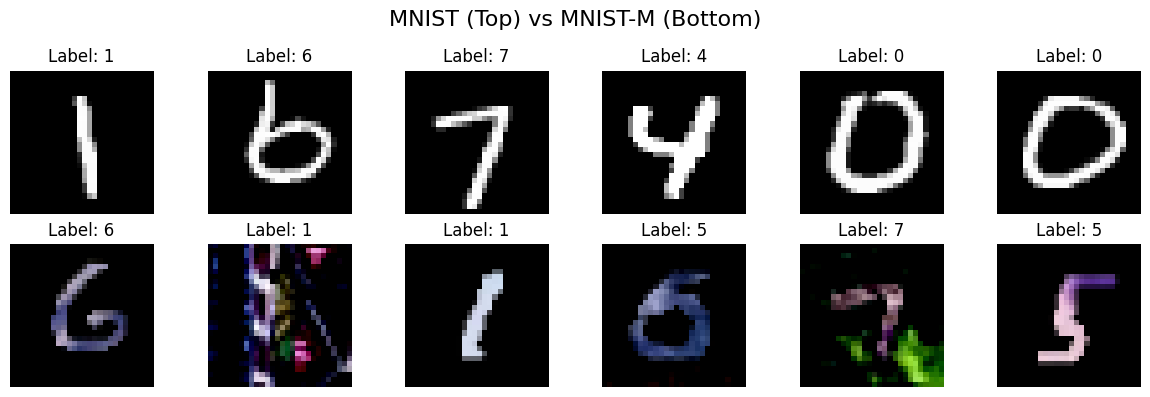

In [ ]:
show_mnist_and_mnistm_samples(source_loader, target_loader)

## See the data output of dataloaders

In [ ]:
x0_s_train, y0_s_train = next(iter(source_loader))
x0_t_train, y0_t_train = next(iter(target_loader))

print('source domain: ', x0_s_train.shape, y0_s_train.shape)
print('target domain: ', x0_t_train.shape, y0_t_train.shape)

source domain:  torch.Size([128, 3, 28, 28]) torch.Size([128])
target domain:  torch.Size([128, 3, 28, 28]) torch.Size([128])


## 🧠 4. Domain-Adversarial Neural Network (DANN) with Modular Design

We define three key components shared across models:

- `FeatureExtractor`: CNN-based feature learning
- `LabelPredictor`: Predicts the target label
- `DomainClassifier`: Learns to discriminate source vs. target domains via a Gradient Reversal Layer (GRL)

These components are combined differently in Baseline and DANN models.


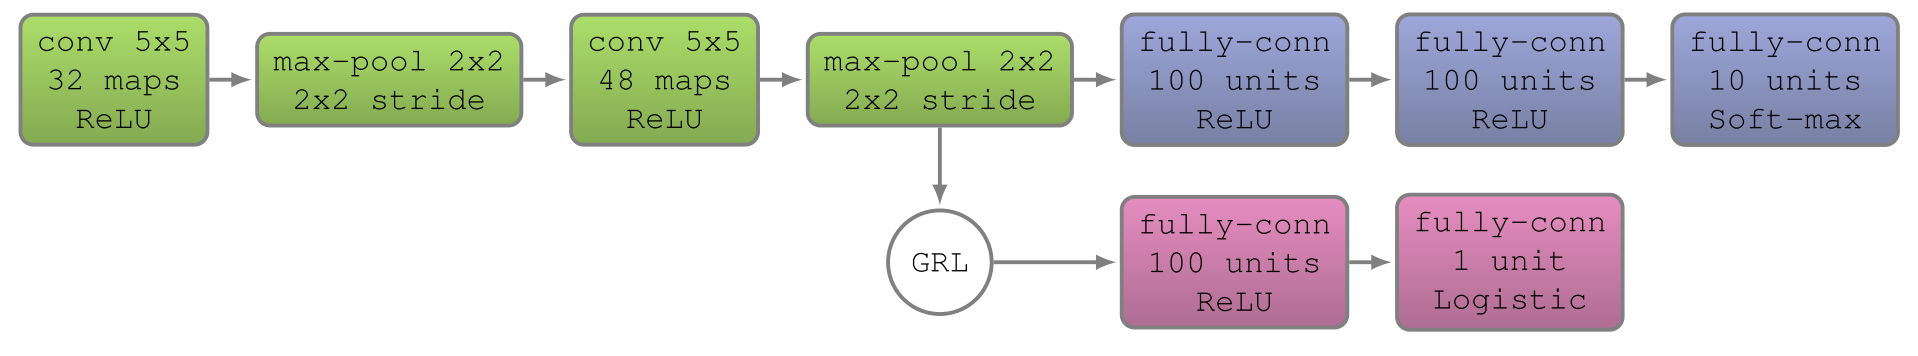

### 🔁 Gradient Reversal Layer (GRL)

The GRL is the core of DANN. It acts as identity during forward pass, but **reverses the gradient** during backpropagation, forcing the feature extractor to learn **domain-invariant** features.


In [ ]:
from torch.autograd import Function
# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def grad_reverse(x, alpha=1.0):
    return GradientReversalFn.apply(x, alpha)


### 🔍 Feature Extractor

A basic CNN that reduces 28×28 RGB images to a compact feature vector of shape `[batch, 50×4×4]`.


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),      # 3x28x28 → 64x24x24
            nn.Dropout(0.05),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                      # 64x12x12

            nn.Conv2d(64, 50, kernel_size=5),     # 50x8x8
            nn.Dropout(0.05),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(2),                      # 50x4x4
        )

    def forward(self, x):
        return self.model(x)

### 🏷️ Label Predictor

A simple MLP that predicts task labels (e.g., digits 0-9 for MNIST-like tasks) from flattened features.


In [ ]:
class LabelPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100),  # FC1
            nn.Dropout(0.05),
            nn.ReLU(),

            nn.Linear(100, 100),  # FC2
            nn.Dropout(0.05),
            nn.ReLU(),

            nn.Linear(100, 10),  # FC3
        )

    def forward(self, x):
        return self.classifier(x)


### 🌍 Domain Classifier

Tries to classify whether features come from source or target domain.  
The GRL makes this task adversarial to the feature extractor.


In [ ]:
class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.domain = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), # FC1
            nn.Dropout(0.05),
            nn.ReLU(),

            nn.Linear(100, 2),  # FC2, Domain labels: Source (0) or Target (1)
        )

    def forward(self, x, alpha):
        x = grad_reverse(x, alpha)
        return self.domain(x)


### 🎯 Baseline Model (No Domain Adaptation)

The baseline model shares the same architecture for the feature extractor and label predictor.  
It trains only on the source domain and doesn't try to learn domain-invariant features.

Baseline model uses:

- Feature Extractor
- Label Predictor

It is trained using only source (MNIST) data without any domain adaptation.

Use it as a reference to evaluate how much **domain shift hurts** performance on the target domain.


In [ ]:
# Baseline model: Feature Extractor + Label Classifier only

class Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.label_predictor = LabelPredictor()

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        class_output = self.label_predictor(features)
        return class_output


In [ ]:
# Dummy input for testing
x = torch.randn(16, 3, 28, 28)

baseline_model = Baseline()
class_output = baseline_model(x)

print("Class Output Shape:", class_output.shape)  # [16, 10]
print("baseline model \n", baseline_model)

Class Output Shape: torch.Size([16, 10])
baseline model 
 Baseline(
  (feature_extractor): FeatureExtractor(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): Dropout(p=0.05, inplace=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
      (6): Dropout(p=0.05, inplace=False)
      (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (label_predictor): LabelPredictor(
    (classifier): Sequential(
      (0): Linear(in_features=800, out_features=100, bias=True)
      (1): Dropout(p=0.05, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      

In [ ]:
!pip install torchinfo
from torchinfo import summary

temp_model = Baseline().to(DEVICE)
batch_size = 2
summary(temp_model, input_size=(batch_size, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Baseline                                 [2, 10]                   --
├─FeatureExtractor: 1-1                  [2, 50, 4, 4]             --
│    └─Sequential: 2-1                   [2, 50, 4, 4]             --
│    │    └─Conv2d: 3-1                  [2, 64, 24, 24]           4,864
│    │    └─Dropout: 3-2                 [2, 64, 24, 24]           --
│    │    └─BatchNorm2d: 3-3             [2, 64, 24, 24]           128
│    │    └─ReLU: 3-4                    [2, 64, 24, 24]           --
│    │    └─MaxPool2d: 3-5               [2, 64, 12, 12]           --
│    │    └─Conv2d: 3-6                  [2, 50, 8, 8]             80,050
│    │    └─Dropout: 3-7                 [2, 50, 8, 8]             --
│    │    └─BatchNorm2d: 3-8             [2, 50, 8, 8]             100
│    │    └─ReLU: 3-9                    [2, 50, 8, 8]             --
│    │    └─MaxPool2d: 3-10              [2, 50, 4, 4]             --
├─Labe

### 🧩 Combined DANN Model

We package the three components to get `class_output` and `domain_output`.  
During training, the `alpha` parameter increases gradually to strengthen the adversarial signal.

The DANN model extends the Baseline by adding:

- Domain Classifier
- Gradient Reversal Layer

This allows the model to learn domain-invariant features by confusing the domain classifier while still being accurate on label prediction.


In [ ]:
class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.label_predictor = LabelPredictor()
        self.domain_classifier = DomainClassifier()

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)

        class_output = self.label_predictor(features)
        domain_output = self.domain_classifier(features, alpha)
        return class_output, domain_output


### 🧪 Section 7: Quick Test


In [ ]:
# Dummy input: batch of 16 images (3x28x28)
x = torch.randn(2, 3, 28, 28)

model = DANN()
class_pred, domain_pred = model(x, alpha=1.0)

print("Class Output Shape:", class_pred.shape)
print(f'Class output \n {class_pred}')
print("Domain Output Shape:", domain_pred.shape)
print(f'Domain output \n {domain_pred}')

print("Model:\n", model)

Class Output Shape: torch.Size([2, 10])
Class output 
 tensor([[-0.0242,  0.1681, -0.1355,  0.0114, -0.1395,  0.1400,  0.0176, -0.0368,
          0.0517, -0.2140],
        [-0.0953,  0.1686, -0.1469,  0.0683,  0.0240, -0.0297, -0.0014, -0.0061,
         -0.0312, -0.2520]], grad_fn=<AddmmBackward0>)
Domain Output Shape: torch.Size([2, 2])
Domain output 
 tensor([[-0.2042, -0.2979],
        [-0.0542, -0.3954]], grad_fn=<AddmmBackward0>)
Model:
 DANN(
  (feature_extractor): FeatureExtractor(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): Dropout(p=0.05, inplace=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 50, kernel_size=(5, 5), stride=(1, 1))
      (6): Dropout(p=0.05, inplace=False)
      (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_st

### ✅ Output Check

You should see:
- `Class Output Shape: [16, 10]`
- `Domain Output Shape: [16, 2]`

This confirms both tasks (label and domain classification) are working.


In [ ]:
!pip install torchinfo
from torchinfo import summary

temp_model = DANN().to(DEVICE)
batch_size = 2
summary(temp_model, input_size=(batch_size, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DANN                                     [2, 10]                   --
├─FeatureExtractor: 1-1                  [2, 50, 4, 4]             --
│    └─Sequential: 2-1                   [2, 50, 4, 4]             --
│    │    └─Conv2d: 3-1                  [2, 64, 24, 24]           4,864
│    │    └─Dropout: 3-2                 [2, 64, 24, 24]           --
│    │    └─BatchNorm2d: 3-3             [2, 64, 24, 24]           128
│    │    └─ReLU: 3-4                    [2, 64, 24, 24]           --
│    │    └─MaxPool2d: 3-5               [2, 64, 12, 12]           --
│    │    └─Conv2d: 3-6                  [2, 50, 8, 8]             80,050
│    │    └─Dropout: 3-7                 [2, 50, 8, 8]             --
│    │    └─BatchNorm2d: 3-8             [2, 50, 8, 8]             100
│    │    └─ReLU: 3-9                    [2, 50, 8, 8]             --
│    │    └─MaxPool2d: 3-10              [2, 50, 4, 4]             --
├─Labe

## 5.Training & Comparison

We train both models:
- Baseline on MNIST only.
- DANN on MNIST + MNIST-M

Then we compare performance on MNIST-M test set.

Also, we can visualize:
- t-SNE plots of feature embeddings
- Confusion matrix
- Accuracy comparison plots over epochs


### 📌 Training & Evaluation Functions

We define separate training loops for:
- `train_baseline`: Only trains on MNIST.
- `train_dann`: Trains on both MNIST and MNIST-M using adversarial loss with Gradient Reversal.

We track and print training loss and accuracy on the target domain after each epoch.

We evaluate results on target loader

### 🔍Learning Rate Finder




In [ ]:
def lr_finder(model, train_loader, optimizer, criterion, init_value=1e-7, final_value=10, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr

    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1

        # forward pass
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # smooth loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # record the values
        log_lrs.append(np.log10(lr))
        losses.append(smoothed_loss)

        # stop if loss explodes
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        # record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

        # backward pass
        loss.backward()
        optimizer.step()

        # increase the LR
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    # plot
    plt.plot(log_lrs[10:-5], losses[10:-5])
    plt.xlabel("log10(Learning Rate)")
    plt.ylabel("Loss")
    plt.title("LR Finder")
    plt.show()


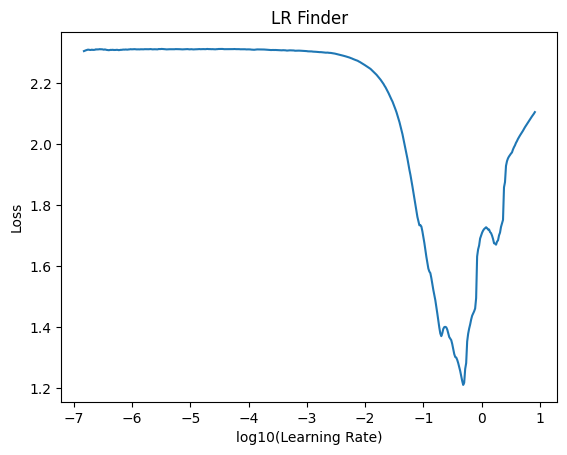

In [ ]:
model = Baseline().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()
lr_finder(model, source_loader, optimizer, criterion)

max learning rate can be between 0.1 and 0.01, we can put learning rate as 0.01 and 0.001

###  ✅ Evaluation

Evaluate models using classification accuracy on target domain (MNIST-M test set).

In [ ]:
def evaluate(model, data_loader, num_model_output = 1):
    """
    Evaluate accuracy on a given data_loader (typically the target domain).
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            if num_model_output == 1:
              outputs = model(images)
            else:
              outputs = model(images)[0]
            pred = outputs.argmax(dim=1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return 100. * correct / total

In [ ]:
# ⏱️ Training Loop for Baseline Model
def train_baseline(model, train_loader, val_loader, optimizer, epoch=0):
    """
    Train a classifier on source domain data only.

    Args:
        model: Classifier model with feature extractor + label classifier
        train_loader: Source domain dataloader
        val_loader: Target domain validation loader (for evaluation)
        optimizer: Optimizer (Adam/SGD)
        epoch: Current Training Epoch
    """

    model.to(DEVICE)
    criterion_label = nn.CrossEntropyLoss()

    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"[Baseline] Epoch {epoch+1}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion_label(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Validation Accuracy: {acc:.2f}%")
    return acc, avg_loss

### 🚀 Training the baseline

In [ ]:
num_epochs = 10 #2 #10

In [ ]:
baseline_model = Baseline()
# baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
baseline_optimizer = torch.optim.SGD(baseline_model.parameters(), lr=.005, momentum = 0.9)

baseline_target_accs = []
baseline_source_accs = []
baseline_source_loss = []


for epoch in range(num_epochs):
    source_accuracy, source_loss = train_baseline(baseline_model, source_loader, source_test_loader, baseline_optimizer, epoch = epoch)
    baseline_source_accs.append(source_accuracy)
    baseline_source_loss.append(source_loss)
    target_accuracy = evaluate(baseline_model, target_test_loader)
    print(f"Target Accuracy: {target_accuracy:.2f}%")
    baseline_target_accs.append(target_accuracy)

[Baseline] Epoch 1: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]


Epoch 1, Loss: 0.3348, Validation Accuracy: 97.96%
Target Accuracy: 31.12%


[Baseline] Epoch 2: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]


Epoch 2, Loss: 0.0632, Validation Accuracy: 98.67%
Target Accuracy: 28.68%


[Baseline] Epoch 3: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]


Epoch 3, Loss: 0.0459, Validation Accuracy: 99.09%
Target Accuracy: 36.76%


[Baseline] Epoch 4: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]


Epoch 4, Loss: 0.0350, Validation Accuracy: 98.85%
Target Accuracy: 29.96%


[Baseline] Epoch 5: 100%|██████████| 469/469 [00:18<00:00, 25.09it/s]


Epoch 5, Loss: 0.0299, Validation Accuracy: 99.12%
Target Accuracy: 32.22%


[Baseline] Epoch 6: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]


Epoch 6, Loss: 0.0245, Validation Accuracy: 99.21%
Target Accuracy: 35.26%


[Baseline] Epoch 7: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]


Epoch 7, Loss: 0.0211, Validation Accuracy: 99.25%
Target Accuracy: 32.28%


[Baseline] Epoch 8: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]


Epoch 8, Loss: 0.0184, Validation Accuracy: 99.24%
Target Accuracy: 35.92%


[Baseline] Epoch 9: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]


Epoch 9, Loss: 0.0156, Validation Accuracy: 99.29%
Target Accuracy: 38.06%


[Baseline] Epoch 10: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]


Epoch 10, Loss: 0.0145, Validation Accuracy: 99.28%
Target Accuracy: 36.94%


In [ ]:
baseline_target_accs ,baseline_source_accs,baseline_source_loss

([31.12, 28.68, 36.76, 29.96, 32.22, 35.26, 32.28, 35.92, 38.06, 36.94],
 [97.96, 98.67, 99.09, 98.85, 99.12, 99.21, 99.25, 99.24, 99.29, 99.28],
 [0.33481241451270544,
  0.06316775787296071,
  0.04587493193740927,
  0.034966478888779434,
  0.029890435556672625,
  0.02448672949915319,
  0.021070599180660142,
  0.01840557828970027,
  0.01560525560733189,
  0.014492890449302362])

In [ ]:
def train_dann(model, source_loader, source_test_loader, target_loader, optimizer, num_epochs=10, epoch=0, alpha=None):
    """
    Train a DANN model using source and target domain data.

    Args:
        model: DANN model with feature extractor, label and domain classifier
        source_loader: Dataloader for labeled source data, train split
        source_test_loader : Dataloader for labeled source data, validation /test split
        target_loader: Dataloader for unlabeled target data, train split
        optimizer: Optimizer for model
        num_epochs: Total training epochs
        epoch: current epoch
        alpha: Optional external alpha. If None, use dynamic alpha scheduling.
    """
    model.to(DEVICE)
    len_dataloader = min(len(source_loader), len(target_loader))
    criterion_label = nn.CrossEntropyLoss()
    criterion_domain = nn.BCEWithLogitsLoss()
    total_loss = 0
    current_alpha = 0

    i = 0 # as the training progresses the alpha changes
    while i < len_dataloader -1:
      # 📈 Dynamic alpha scheduling if not provided
      # implementation as per paper
      if alpha is None:
          p = float(i + epoch * len_dataloader) / (num_epochs * len_dataloader)
          current_alpha = 2. / (1. + np.exp(-10 * p)) - 1
      else:
          current_alpha = alpha

      # Train on source domain
      X_s,y_s = next(iter(source_loader))
      X_s,y_s = X_s.to(DEVICE),y_s.to(DEVICE)

      # 🔁 Domain labels: 0 for source
      domain_label_s =  torch.tensor([[1, 0]] * X_s.size(0)).long().to(DEVICE) #torch.zeros(X_s.size(0)).long().to(DEVICE)

      # Train on tarhet domain
      X_t, _ = next(iter(target_loader))
      X_t = X_t.to(DEVICE)

      # 🔁 Domain labels: 1 for target
      domain_label_t =  torch.tensor([[0, 1]] * X_t.size(0)).long().to(DEVICE)#torch.ones(X_t.size(0)).long().to(DEVICE)

      optimizer.zero_grad()

      # 🧠 Forward pass
      class_output, domain_output_s = model(X_s, alpha=current_alpha)
      _, domain_output_t = model(X_t, alpha=current_alpha)

      domain_output = torch.cat([domain_output_s, domain_output_t], dim=0)
      domain_label = torch.cat([domain_label_s, domain_label_t], dim=0)

      # print(f' domain output shape = {domain_output.shape}, domain_label shape = {domain_label.shape}')

      # 🎯 Losses
      class_loss = criterion_label(class_output, y_s)
      domain_loss = criterion_domain(domain_output, domain_label.float())

      loss = class_loss + domain_loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      i = i+1 # increament loop

    avg_loss = total_loss / len_dataloader
    acc = evaluate(model, source_test_loader, num_model_output=2)
    print(f"[DANN] Epoch {epoch+1}, Loss: {avg_loss:.4f}, Validation Accuracy: {acc:.2f}%, Current Alpha: {current_alpha:.4f}")
    return acc, avg_loss


Wait, but why let $\alpha$ (`alpha` in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradualy changed from 0 to 1 in the course of training.
    $$
    \alpha_p = \frac{2}{1+\exp(-10\cdot p)} -1,
    $$
    where $p\in[0,1]$ is the training progress.

## 🚀 Training DANN

In [ ]:
dann_model = DANN()
# dann_optimizer = torch.optim.Adam(dann_model.parameters(), lr=1e-3)
dann_optimizer = torch.optim.SGD(dann_model.parameters(), lr=.005, momentum = 0.9)

dann_target_accs = []
dann_source_accs = []
dann_source_loss = []


for epoch in range(num_epochs):
    source_accuracy, source_loss = train_dann(dann_model, source_loader, source_test_loader, target_loader, dann_optimizer, num_epochs=num_epochs, epoch=epoch, alpha=None)
    dann_source_accs.append(source_accuracy)
    dann_source_loss.append(source_loss)
    target_accuracy = evaluate(dann_model, target_test_loader,num_model_output=2)
    print(f"Target Accuracy: {target_accuracy:.2f}%")
    dann_target_accs.append(target_accuracy)



[DANN] Epoch 1, Loss: 1.4280, Validation Accuracy: 96.04%, Current Alpha: 0.4571
Target Accuracy: 51.46%
[DANN] Epoch 2, Loss: 1.7799, Validation Accuracy: 81.94%, Current Alpha: 0.7589
Target Accuracy: 27.28%
[DANN] Epoch 3, Loss: 0.6402, Validation Accuracy: 94.10%, Current Alpha: 0.9040
Target Accuracy: 37.30%
[DANN] Epoch 4, Loss: 0.5414, Validation Accuracy: 87.31%, Current Alpha: 0.9636
Target Accuracy: 34.14%
[DANN] Epoch 5, Loss: 0.6309, Validation Accuracy: 96.02%, Current Alpha: 0.9864
Target Accuracy: 43.54%
[DANN] Epoch 6, Loss: 0.5839, Validation Accuracy: 96.23%, Current Alpha: 0.9950
Target Accuracy: 50.74%
[DANN] Epoch 7, Loss: 0.7612, Validation Accuracy: 95.35%, Current Alpha: 0.9982
Target Accuracy: 45.36%
[DANN] Epoch 8, Loss: 0.6398, Validation Accuracy: 94.99%, Current Alpha: 0.9993
Target Accuracy: 50.34%
[DANN] Epoch 9, Loss: 0.6082, Validation Accuracy: 96.47%, Current Alpha: 0.9998
Target Accuracy: 50.66%
[DANN] Epoch 10, Loss: 0.6806, Validation Accuracy: 96.

In [ ]:
dann_target_accs, dann_source_accs, dann_source_loss

([51.46, 27.28, 37.3, 34.14, 43.54, 50.74, 45.36, 50.34, 50.66, 48.28],
 [96.04, 81.94, 94.1, 87.31, 96.02, 96.23, 95.35, 94.99, 96.47, 96.01],
 [1.4279991031452348,
  1.7798972450623847,
  0.6402349631497815,
  0.5414366419338117,
  0.6309048620758543,
  0.5838993093010726,
  0.7612277126995621,
  0.6398130702744623,
  0.6082257920769369,
  0.6806490721216627])

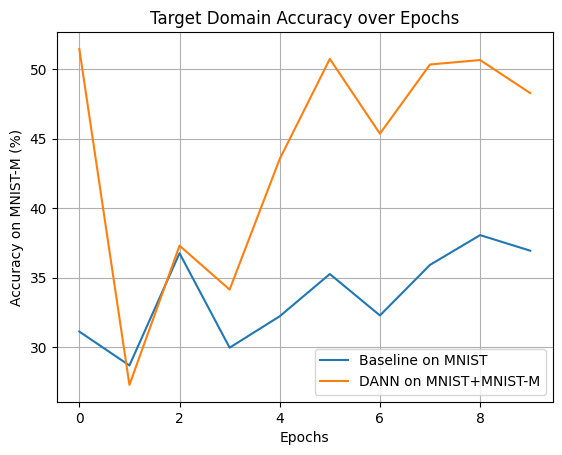

In [ ]:
import matplotlib.pyplot as plt

plt.plot(baseline_target_accs, label='Baseline on MNIST')
plt.plot(dann_target_accs, label='DANN on MNIST+MNIST-M')
plt.xlabel("Epochs")
plt.ylabel("Accuracy on MNIST-M (%)")
plt.title("Target Domain Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## 6.📊 Checking feature distribution for DANN and Baseline

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def extract_features(model, loader,  max_samples = 100, domain = 'target'):
    model.eval()
    total_samples = 0
    features, labels, domains = [], [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            feat = model.feature_extractor(imgs)
            feat = feat.view(feat.size(0),-1) # flattened to [Batch_size, feature_dim]
            features.append(feat.cpu())
            labels.append(lbls)
            # if domain == 'target':
            #   domains.append(np.ones(len(lbls)))
            # else:
            #   domains.append(np.zeros(len(lbls)))

            domain_label = 0 if domain == 'target' else 1
            domains.append(torch.full((len(lbls),), domain_label))  # torch.ones or torch.zeros

            total_samples += batch_size
            if total_samples >= max_samples:
                break
    return torch.cat(features), torch.cat(labels), torch.cat(domains)




### 📊Checking feature distribution for Baseline

In [ ]:
features_target, labels_target, domains_target = extract_features(baseline_model, target_loader)
features_source, labels_source, domains_source = extract_features(baseline_model, source_loader, domain = 'source')


all_features = torch.cat([features_source, features_target], dim=0)
all_labels = torch.cat([labels_source, labels_target], dim=0)
all_domains = torch.cat([domains_source, domains_target], dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(all_features.numpy())

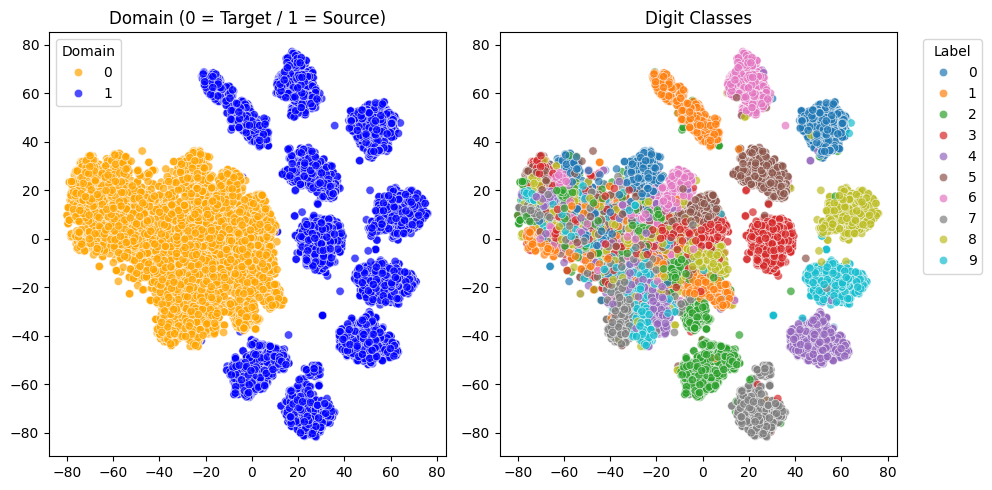

In [ ]:
# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_domains, palette=['orange', 'blue'], alpha=0.7)
plt.title("Domain (0 = Target / 1 = Source)")
plt.legend(title="Domain")


plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_labels, palette='tab10', alpha=0.7)
plt.title("Digit Classes")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 📊 Checking feature distribution for DANN

In [ ]:
features_target, labels_target, domains_target = extract_features(dann_model, target_loader)
features_source, labels_source, domains_source = extract_features(dann_model, source_loader, domain = 'source')


all_features = torch.cat([features_source, features_target], dim=0)
all_labels = torch.cat([labels_source, labels_target], dim=0)
all_domains = torch.cat([domains_source, domains_target], dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(all_features.numpy())

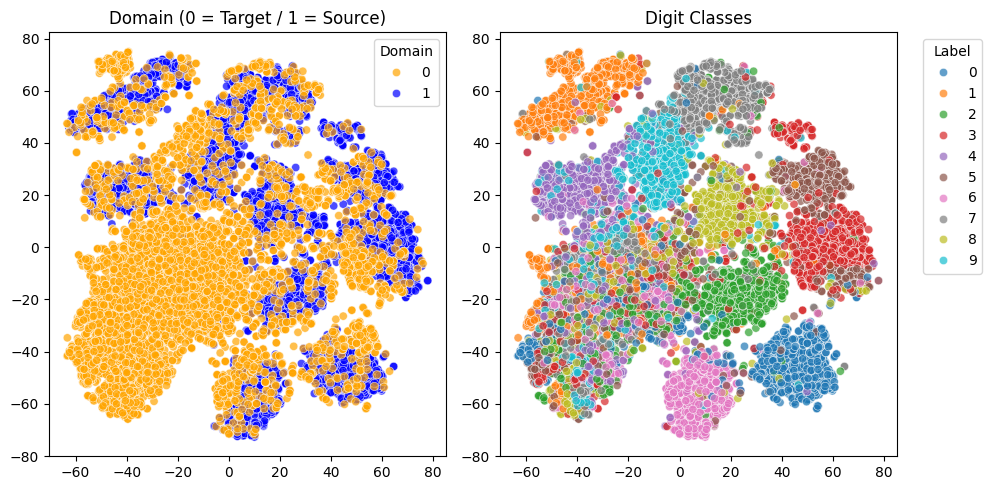

In [ ]:
# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_domains, palette=['orange', 'blue'], alpha=0.7)
plt.title("Domain (0 = Target / 1 = Source)")
plt.legend(title="Domain")


plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_labels, palette='tab10', alpha=0.7)
plt.title("Digit Classes")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 7.🎯Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            if isinstance(out, tuple):
              out = out[0]
            preds += out.argmax(1).cpu().tolist()
            targets += lbls.tolist()
    return preds, targets

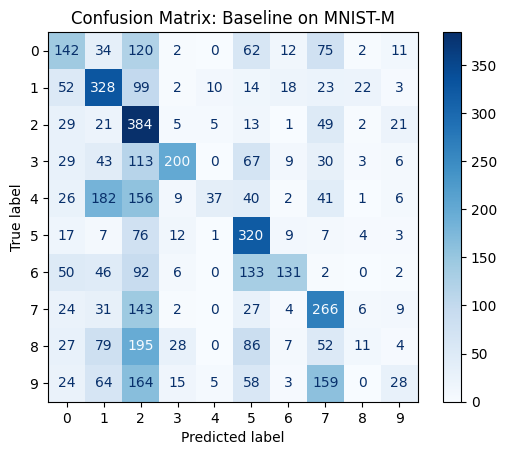

In [ ]:
preds, targets = get_predictions(baseline_model, target_test_loader)
cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Baseline on MNIST-M")
plt.show()

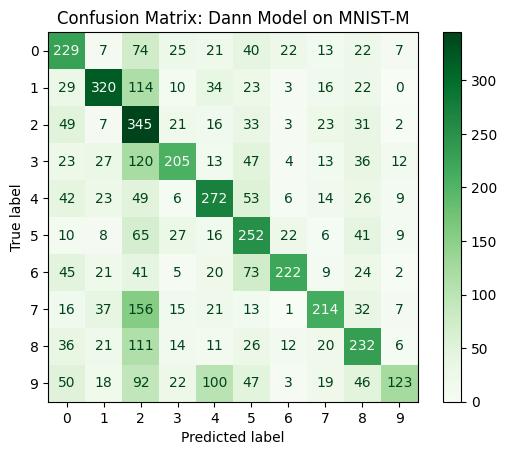

In [ ]:
preds, targets = get_predictions(dann_model, target_test_loader)
cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Greens")
plt.title("Confusion Matrix: Dann Model on MNIST-M")
plt.show()

## 8. Accuracy

In [ ]:
baseline_acc = evaluate(baseline_model, target_loader)
dann_acc = evaluate(dann_model, target_loader,num_model_output = 2)

print(f"🎯 Baseline Accuracy on MNIST-M: {baseline_acc:.2f}%")
print(f"🎯 DANN Accuracy on MNIST-M: {dann_acc:.2f}%")


🎯 Baseline Accuracy on MNIST-M: 37.33%
🎯 DANN Accuracy on MNIST-M: 48.88%


### Accuracy over training

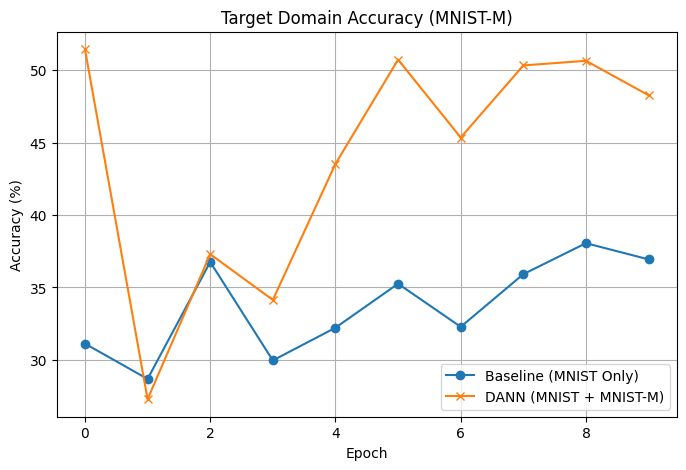

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(baseline_acc_list, dann_acc_list):
    plt.figure(figsize=(8, 5))
    plt.plot(baseline_acc_list, label='Baseline (MNIST Only)', marker='o')
    plt.plot(dann_acc_list, label='DANN (MNIST + MNIST-M)', marker='x')
    plt.title("Target Domain Accuracy (MNIST-M)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_accuracy(baseline_target_accs, dann_target_accs)

## 9. Effect of α (Gradient Reversal Weight)

In DANN, the gradient reversal layer uses a dynamic alpha value during training that increases as training progresses:

- α = 0: No domain confusion (behaves like Baseline)
- α = 1: Full domain confusion (strong adversarial training)

We evaluate how changing α affects the domain alignment and final accuracy using t-SNE plots.


In [63]:
dann_model_1 = DANN()
dann_optimizer = torch.optim.SGD(dann_model_1.parameters(), lr=.005, momentum = 0.9)

dann_1_target_accs = []
dann_1_source_accs = []
dann_1_source_loss = []


for epoch in range(num_epochs):
    source_accuracy, source_loss = train_dann(dann_model_1, source_loader, source_test_loader, target_loader, dann_optimizer, num_epochs=num_epochs, epoch=epoch, alpha=1.0)
    dann_1_source_accs.append(source_accuracy)
    dann_1_source_loss.append(source_loss)
    target_accuracy = evaluate(dann_model_1, target_test_loader,num_model_output=2)
    print(f"Target Accuracy: {target_accuracy:.2f}%")
    dann_1_target_accs.append(target_accuracy)

[DANN] Epoch 1, Loss: 1.5564, Validation Accuracy: 95.12%, Current Alpha: 1.0000
Target Accuracy: 50.38%
[DANN] Epoch 2, Loss: 2.6193, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.36%
[DANN] Epoch 3, Loss: 2.8309, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.42%
[DANN] Epoch 4, Loss: 2.8896, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.40%
[DANN] Epoch 5, Loss: 2.8357, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.42%
[DANN] Epoch 6, Loss: 2.8118, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.42%
[DANN] Epoch 7, Loss: 2.8596, Validation Accuracy: 11.35%, Current Alpha: 1.0000
Target Accuracy: 11.40%
[DANN] Epoch 8, Loss: 2.8977, Validation Accuracy: 30.03%, Current Alpha: 1.0000
Target Accuracy: 15.84%
[DANN] Epoch 9, Loss: 1.8014, Validation Accuracy: 81.82%, Current Alpha: 1.0000
Target Accuracy: 34.00%
[DANN] Epoch 10, Loss: 1.0084, Validation Accuracy: 89.

In [64]:
dann_model_0 = DANN()
dann_optimizer = torch.optim.SGD(dann_model_0.parameters(), lr=.005, momentum = 0.9)

dann_0_target_accs = []
dann_0_source_accs = []
dann_0_source_loss = []


for epoch in range(num_epochs):
    source_accuracy, source_loss = train_dann(dann_model_0, source_loader, source_test_loader, target_loader, dann_optimizer, num_epochs=num_epochs, epoch=epoch, alpha=0.0)
    dann_0_source_accs.append(source_accuracy)
    dann_0_source_loss.append(source_loss)
    target_accuracy = evaluate(dann_model_0, target_test_loader,num_model_output=2)
    print(f"Target Accuracy: {target_accuracy:.2f}%")
    dann_0_target_accs.append(target_accuracy)

[DANN] Epoch 1, Loss: 1.0906, Validation Accuracy: 96.15%, Current Alpha: 0.0000
Target Accuracy: 47.86%
[DANN] Epoch 2, Loss: 0.1614, Validation Accuracy: 97.74%, Current Alpha: 0.0000
Target Accuracy: 39.50%
[DANN] Epoch 3, Loss: 0.0842, Validation Accuracy: 98.39%, Current Alpha: 0.0000
Target Accuracy: 38.42%
[DANN] Epoch 4, Loss: 0.0664, Validation Accuracy: 98.28%, Current Alpha: 0.0000
Target Accuracy: 42.48%
[DANN] Epoch 5, Loss: 0.0484, Validation Accuracy: 98.67%, Current Alpha: 0.0000
Target Accuracy: 41.26%
[DANN] Epoch 6, Loss: 0.0442, Validation Accuracy: 98.71%, Current Alpha: 0.0000
Target Accuracy: 35.28%
[DANN] Epoch 7, Loss: 0.0467, Validation Accuracy: 98.87%, Current Alpha: 0.0000
Target Accuracy: 44.12%
[DANN] Epoch 8, Loss: 0.0392, Validation Accuracy: 98.76%, Current Alpha: 0.0000
Target Accuracy: 38.36%
[DANN] Epoch 9, Loss: 0.0300, Validation Accuracy: 99.15%, Current Alpha: 0.0000
Target Accuracy: 40.72%
[DANN] Epoch 10, Loss: 0.0252, Validation Accuracy: 99.

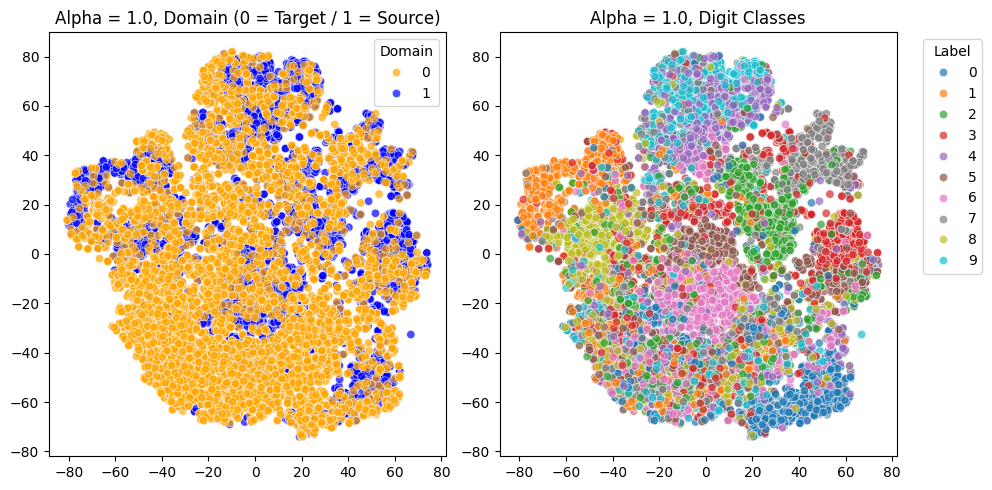

In [65]:
features_target, labels_target, domains_target = extract_features(dann_model_1, target_loader)
features_source, labels_source, domains_source = extract_features(dann_model_1, source_loader, domain = 'source')


all_features = torch.cat([features_source, features_target], dim=0)
all_labels = torch.cat([labels_source, labels_target], dim=0)
all_domains = torch.cat([domains_source, domains_target], dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(all_features.numpy())

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_domains, palette=['orange', 'blue'], alpha=0.7)
plt.title("Alpha = 1.0, Domain (0 = Target / 1 = Source)")
plt.legend(title="Domain")


plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_labels, palette='tab10', alpha=0.7)
plt.title("Alpha = 1.0, Digit Classes")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

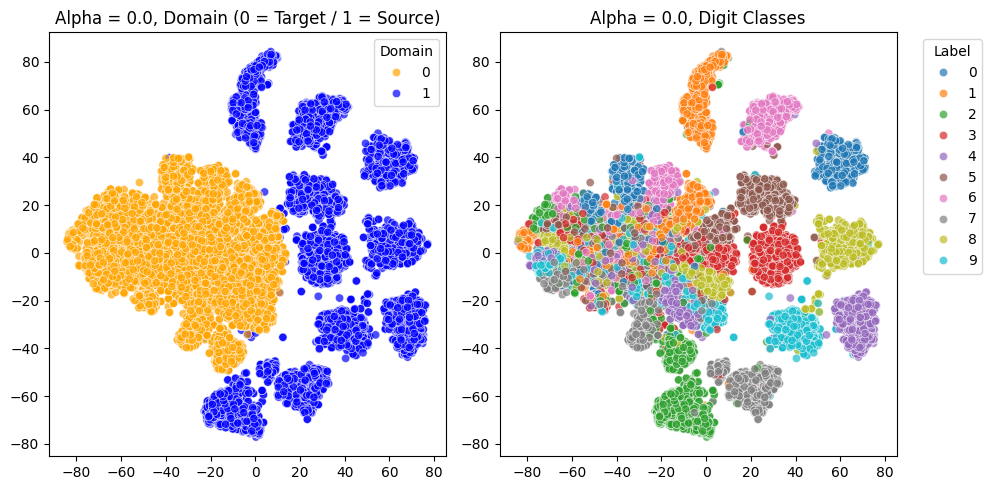

In [66]:
features_target, labels_target, domains_target = extract_features(dann_model_0, target_loader)
features_source, labels_source, domains_source = extract_features(dann_model_0, source_loader, domain = 'source')


all_features = torch.cat([features_source, features_target], dim=0)
all_labels = torch.cat([labels_source, labels_target], dim=0)
all_domains = torch.cat([domains_source, domains_target], dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(all_features.numpy())

# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_domains, palette=['orange', 'blue'], alpha=0.7)
plt.title("Alpha = 0.0, Domain (0 = Target / 1 = Source)")
plt.legend(title="Domain")


plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=all_labels, palette='tab10', alpha=0.7)
plt.title("Alpha = 0.0, Digit Classes")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 10. Conclusion

- The DANN model significantly improves performance on the target domain compared to the baseline.
- Domain Adaptation helps learn domain-invariant features.
- Gradient Reversal and adversarial domain training is effective even with no target labels.

**Future Work:**
- Try other adaptation strategies (e.g., MMD, CORAL)
- Adapt to real-world domains (e.g., SVHN, Synthetic digits)
